This notebook reveals my solution for __RFM Analysis Task__ offered by Renat Alimbekov. 

This task is part of the __Task Series__ for Data Analysts/Scientists
__Task Series__ - is a rubric where Alimbekov challenges his followers to solve tasks and share their solutions.
So here I am :)

Original solution can be found at - https://alimbekov.com/rfm-python/

The task is to perform RFM Analysis. 
* __olist_orders_dataset.csv__ and __olist_order_payments_dataset.csv__ should be used
* order_delivered_carrier_date - should be used in this task
* Since the dataset is not actual by 2021, thus we should assume that we were asked to perform RFM analysis the day after the last record


# Importing the modules

In [17]:
import pandas as pd
import numpy as np

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [18]:
orders = pd.read_csv('input/olist_orders_dataset.csv')
payments = pd.read_csv('input/olist_order_payments_dataset.csv')

# Dataframes join

In [19]:
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date']) # datetime conversion
payments = payments.set_index('order_id') # preparation before the join
orders = orders.set_index('order_id') # preparation before the join

joined = orders.join(payments) # join on order_id

In [20]:
joined.isna()\
      .sum()\
      .sort_values(ascending=False)

order_delivered_customer_date    3132
order_delivered_carrier_date     1888
order_approved_at                 175
payment_value                       1
payment_installments                1
payment_type                        1
payment_sequential                  1
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
customer_id                         0
dtype: int64

In [21]:
joined.nunique()\
      .sort_values(ascending=False)

customer_id                      99441
order_purchase_timestamp         98875
order_delivered_customer_date    95664
order_approved_at                90733
order_delivered_carrier_date     81018
payment_value                    29077
order_estimated_delivery_date      459
payment_sequential                  29
payment_installments                24
order_status                         8
payment_type                         5
dtype: int64

It seems like we have missing values. And unfortunately order_delivered_carrier_date also has missing values. Thus, they should be dropped

In [22]:
last_date = joined['order_delivered_carrier_date'].max() + pd.to_timedelta(1, 'D')

RFM = joined.dropna(subset=['order_delivered_carrier_date'])\
            .reset_index()\
            .groupby('customer_id')\
            .agg(Recency = ('order_delivered_carrier_date', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'))

In [23]:
RFM

,Recency,Frequency,Monetary
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,299,1,114.74
000161a058600d5901f007fab4c27140,420,1,67.41
0001fd6190edaaf884bcaf3d49edf079,560,1,195.42
0002414f95344307404f0ace7a26f1d5,389,1,179.35
000379cdec625522490c315e70c7a9fb,161,1,107.01
...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,179,1,91.91
fffecc9f79fd8c764f843e9951b11341,165,3,81.36
fffeda5b6d849fbd39689bb92087f431,110,1,63.13


Sanity check - do we have NaN values or not?

In [24]:
RFM.isna().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [25]:
RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Recency,97658.0,250.511847,152.674579,1.0,21.00,35.00,54.00,127.00,231.00,361.00,478.00,532.000,587.0000,704.00
Frequency,97658.0,1.044451,0.378736,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000,2.0000,29.00
Monetary,97658.0,159.824647,218.553380,0.0,22.38,32.38,39.59,61.93,105.28,176.26,305.77,446.558,1048.6658,13664.08


So, here we can see that we have some outliers in Freqency and Monetary groups. Thus, they should be dropped and be analyzed separately

# Recency

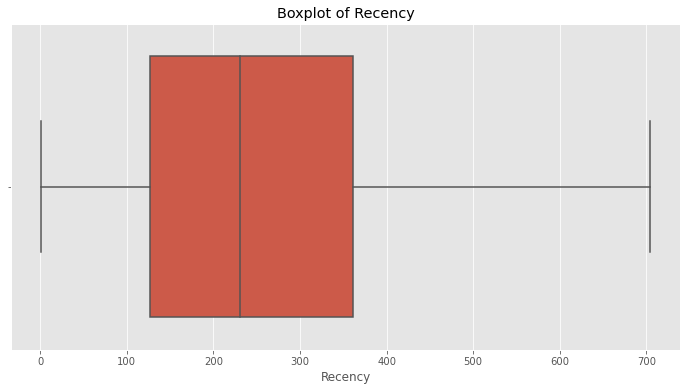

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Recency', data=RFM)
plt.title('Boxplot of Recency');

# Frequency

In [27]:
RFM['Frequency'].value_counts(normalize=True)*100

1     97.025333
2      2.395093
3      0.303099
4      0.108542
5      0.053247
6      0.035839
7      0.028671
8      0.010240
12     0.008192
11     0.008192
9      0.007168
10     0.003072
13     0.003072
14     0.002048
15     0.002048
19     0.002048
26     0.001024
21     0.001024
22     0.001024
29     0.001024
Name: Frequency, dtype: float64

I guess here we should select only frequency values that are greater than 5, because by doing this we only drop 0.11% of records

In [28]:
RFM['Frequency'].apply(lambda x: 'less or equal to 5' if x<=5 else 'greater than 5')\
                .value_counts(normalize=True) * 100

less or equal to 5    99.885314
greater than 5         0.114686
Name: Frequency, dtype: float64

In [29]:
RFM = RFM[RFM['Frequency'] <= 5]

# Monetary

In [30]:
RFM['Monetary'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    97546.000000
mean       159.780566
std        218.510326
min          0.000000
25%         61.880000
50%        105.280000
75%        176.255000
90%        305.680000
95%        446.215000
99%       1048.570000
max      13664.080000
Name: Monetary, dtype: float64

Here, it seems like 95% percentile should be used to drop the outliers

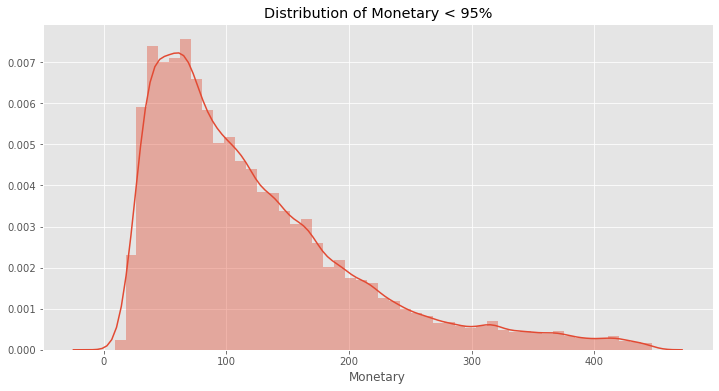

In [31]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of Monetary < 95%')
sns.distplot(RFM[RFM['Monetary']<447].Monetary);

In [32]:
RFM = RFM[RFM['Monetary'] < 447]

# RFM groups

I have used quantiles for assigning scores for Recency and Monetary. 
* groups are 0-33, 33-66, 66-100 quantiles

For Frequency I have decided to group them by hand
* score=1 if the frequency value is 1
* otherwise, the score will be 2

In [33]:
RFM['R_score'] = pd.qcut(RFM['Recency'], 3, labels=[1, 2, 3]).astype(str)
RFM['M_score'] = pd.qcut(RFM['Monetary'], 3, labels=[1, 2, 3]).astype(str)
RFM['F_score'] = RFM['Frequency'].apply(lambda x: '1' if x==1 else '2')

RFM['RFM_score'] = RFM['R_score'] + RFM['F_score'] + RFM['M_score']

1. CORE - '123' - most recent, frequent, revenue generating - core customers that should be considered as most valuable clients
2. GONE - '311', '312', '313' - gone, one-timers - those clients are probably gone;
3. ROOKIE - '111', '112', '113' - just have joined - new clients that have joined recently
4. WHALES - '323', '213', '223 - most revenue generating - whales that generate revenue
5. LOYAL - '221', '222', '321', '322' - loyal users
6. REGULAR - '121', '122', '211', '212', - average users - just regular customers that don't stand out



In [34]:
def segment(x):
    if x == '123':
        return 'Core'
    elif x in ['311', '312', '313']:
        return 'Gone'
    elif x in ['111', '112', '113']:
        return 'Rookies'
    elif x in ['323', '213', '223']:
        return 'Whales'
    elif x in ['221', '222', '321', '322']:
        return 'Loyal'
    else:
        return 'Regular'

In [35]:
RFM['segments'] = RFM['RFM_score'].apply(segment)
RFM['segments'].value_counts(normalize=True)*100

Rookies    32.547099
Gone       32.028097
Regular    22.199443
Whales     11.516217
Loyal       1.440471
Core        0.268672
Name: segments, dtype: float64

In [36]:
segmentwise = RFM.groupby('segments').agg(RecencyMean = ('Recency', 'mean'),
                                          FrequencyMean = ('Frequency', 'mean'),
                                          MonetaryMean = ('Monetary', 'mean'),
                                          GroupSize = ('Recency', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segments,,,,
Core,86.939759,2.220884,221.581847,249
Gone,431.335613,1.000000,122.264921,29683
Loyal,345.632210,2.262921,73.224195,1335
Regular,229.625061,1.031302,74.299787,20574
Rookies,88.471058,1.000000,124.585984,30164
Whales,238.460695,1.062307,220.948326,10673


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


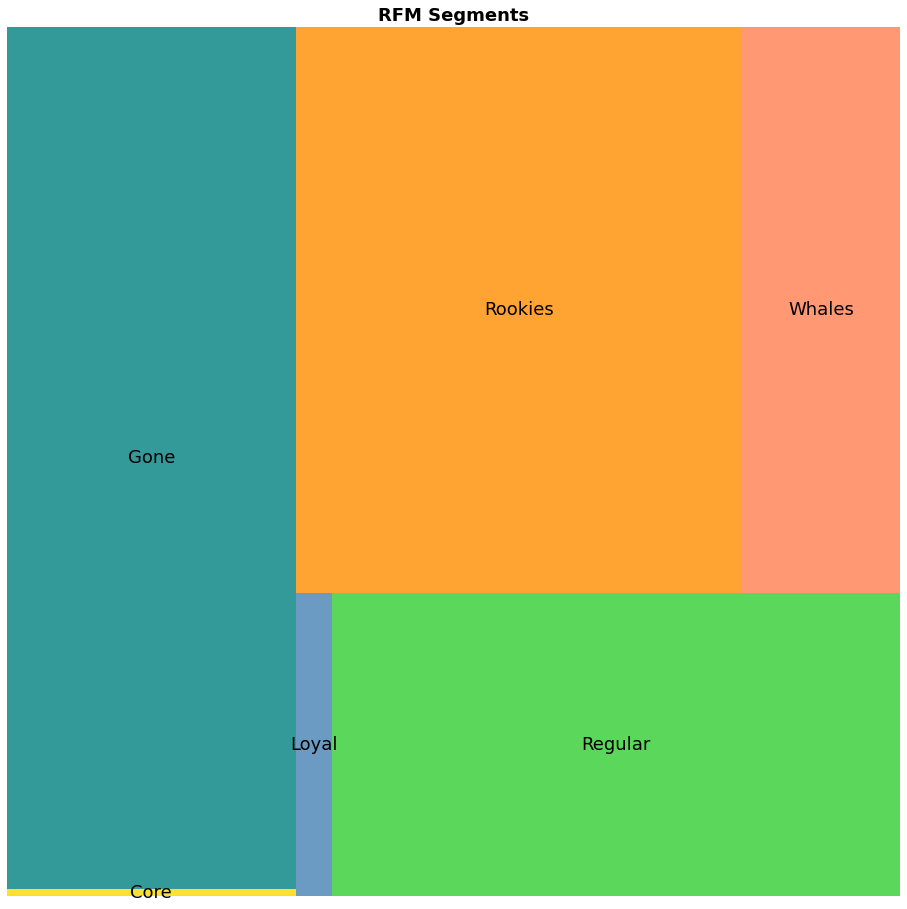

In [37]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 16)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['gold', 'teal', 'steelblue', 'limegreen', 'darkorange', 'coral'],
              alpha = 0.8)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Cohort Analysis


In [46]:
joined

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_months,cohorts
order_id,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,2.0,72.19,2017-09,2017-09
00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1.0,credit_card,3.0,259.83,2017-04,2017-04
000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1.0,credit_card,5.0,216.87,2018-01,2018-01
00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1.0,credit_card,2.0,25.78,2018-08,2018-08
00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1.0,credit_card,3.0,218.04,2017-02,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,1.0,boleto,1.0,343.40,2018-04,2018-04
fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,1.0,boleto,1.0,386.53,2018-07,2018-07
fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00,1.0,credit_card,3.0,116.85,2017-10,2017-10


In [38]:
from operator import attrgetter

joined['order_purchase_timestamp'] = pd.to_datetime(joined['order_purchase_timestamp'])

joined['order_months'] = joined['order_purchase_timestamp'].dt.to_period('M')
joined['cohorts'] = joined.groupby('customer_id')['order_months'].transform('min')

cohorts_data = joined.reset_index()\
                     .groupby(['cohorts', 'order_months'])\
                     .agg(ClientsCount = ('customer_id', 'nunique'),
                          Revenue = ('payment_value', 'sum'),
                          Orders = ('order_id', 'count'))\
                     .reset_index()

cohorts_data['periods'] = (cohorts_data.order_months - cohorts_data.cohorts).apply(attrgetter('n')) # periods for which the client have stayed

cohorts_data.head()

,cohorts,order_months,ClientsCount,Revenue,Orders,periods
0,2016-09,2016-09,4,252.24,4,0
1,2016-10,2016-10,324,59090.48,342,0
2,2016-12,2016-12,1,19.62,1,0
3,2017-01,2017-01,800,138488.04,850,0
4,2017-02,2017-02,1780,291908.01,1886,0


Since, majority of our clients are not recurring ones, we can't perform proper cohort analysis on retention and other possible metrics.

Fortunately, we can analyze dynamics of the bussiness and maybe will be even able to identify some relatively good cohorts that might be used as a prototype (e.g. by marketers).

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


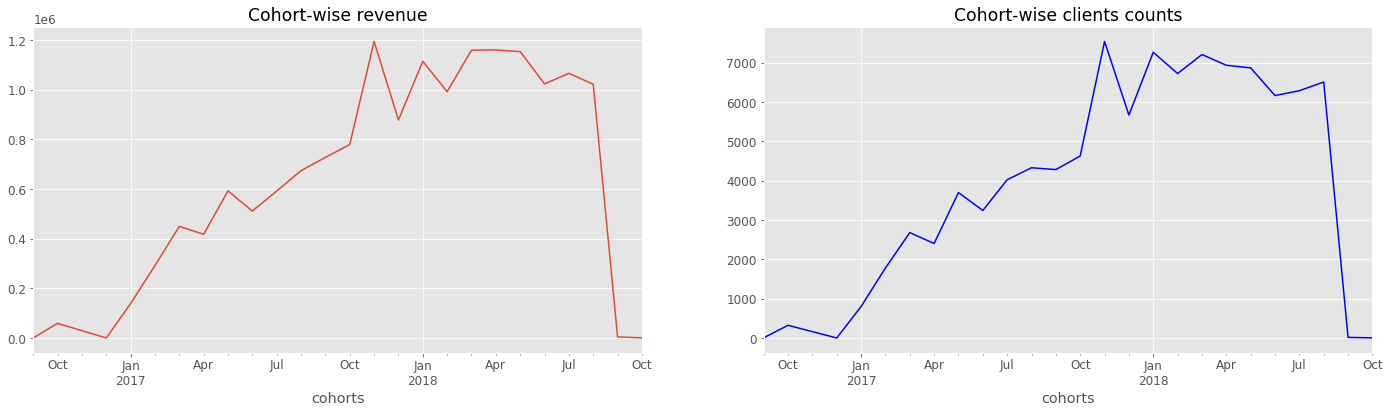

In [39]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6)) # for 2 parrallel plots

cohorts_data.set_index('cohorts').Revenue.plot(ax=ax1)
ax1.set_title('Cohort-wise revenue')

cohorts_data.set_index('cohorts').ClientsCount.plot(ax=ax2, c='b')
ax2.set_title('Cohort-wise clients counts');

The figure above reveals the dynamics of Revenue and Number of Clients per cohort.

On the left side we can see Revenue plot and on the right side can see ClientsCount plot.

Overall, we can come to the next conclusions:
* dynamics of two graphs are almost identical. Thus, it seems like the Average Order Amount was the same almost for each cohort. It could mean that the only way to get more revenue is to get more clients. Also, we know that we have 97% of non-recurring clients, thus maybe resolving this issue and stimulating customers to comeback would also result in revenue increase

* I suspect that we don't have the full data for the last several months, because we can see abnormal drop. Thus, these last months shouldn't be taken into considerations

* Cohort of November-2017 looks like out of trend, since this cohort showed outstanding results. It can be due to Black Friday sales that often happen at Novembers, or maybe during the November of 2017 some experimental marketing campaigns were performed that lead to good results. Thus, this cohort should be investigated by the company in order to identify the reason behind such an outstanding result, and take it into account

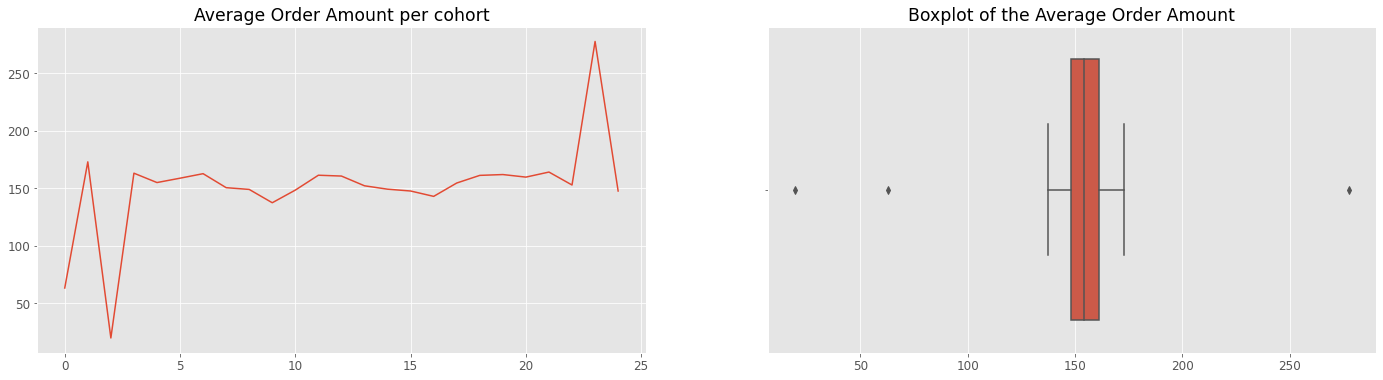

In [40]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))

(cohorts_data['Revenue']/cohorts_data['Orders']).plot(ax=ax1)
ax1.set_title('Average Order Amount per cohort')

sns.boxplot((cohorts_data['Revenue']/cohorts_data['Orders']), ax=ax2)
ax2.set_title('Boxplot of the Average Order Amount');

As it was pointed out above, the average order is the same for almost all the cohors. But we have some outliers that are located at the start and end of the left graph. Those outliers probably should be ignored and we can assume that Average Order Amount is the same for each cohort. Thus, it may imply that the company should work on increasing the number of clients